# Confidence intervals via Constrained Inference - Simulated data

This notebook develops the code for calculating confidence intervals for the causal effect between two variables under the equal variance assumption. It is assumed that the underlying distribution is Gaussian.

Both approaches, standard and two-step, are implemented and can be investigated for different sample sizes $n$, causal effects $\beta$ and variances $\sigma^2$.

Importing packages:

In [17]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm, multivariate_normal
from scipy.optimize import minimize
from pynverse import inversefunc
from joblib import Parallel, delayed

Creation of artifical data and estimation of elements of covariance matrix:

In [18]:
def data_generation(n, beta, sigma, x1_dep = True, seed = 2020):
    np.random.seed(seed)
    y1 = np.random.normal(0, np.sqrt(sigma), n)
    y2 = beta * y1 + np.random.normal(0, np.sqrt(sigma), n)
    x1, x2 = (y2, y1) if x1_dep else (y1, y2)
    return x1, x2

def empirical_sigmas(x1, x2):
    s11 = np.mean(x1**2)
    s12 = np.mean(x1*x2)
    s22 = np.mean(x2**2)
    return s11, s12, s22

## Test statistic

Calculation of the log-likelihood with standard parametrisation and the negative log-likelihood with the concentration matrix $K$ parametrisation:

In [19]:
def llh(x1, x2):
    s11, s12, s22 = empirical_sigmas(x1, x2)
    RV = multivariate_normal([0, 0], [[s11, s12], [s12, s22]])
    L_hat = RV.logpdf(np.stack([x1, x2], axis = 1))
    return np.sum(L_hat)

def nllh_inv(x1, x2):
    """
    a[0], a[1], a[2] <=> k1, k2, k3
    """
    eps = 1e-6
    n = x1.shape[0]
    C = 2*n*np.log(2*np.pi)
    nllh = lambda a: np.inf if a[0]*a[2] - a[1]**2 <= 0\
                            else 0.5 * (C - n*np.log(a[0]*a[2] - a[1]**2)
                                        + np.sum(a[0]*x1**2 + 2*a[1]*x1*x2 + a[2]*x2**2))
    
    grad_nllh = lambda a: np.array([- np.sign(a[2]) * np.inf if a[0]*a[2] - a[1]**2 <= 0\
                                    else 0.5 * (-n*a[2]/(a[0]*a[2]-a[1]**2) + np.sum(x1**2)),
                                    np.sign(a[1]) * np.inf if a[0]*a[2] - a[1]**2 <= 0\
                                    else 1.0 * (n*a[1]/(a[0]*a[2]-a[1]**2) + np.sum(x1*x2)),
                                    -np.sign(a[0]) * np.inf if a[0]*a[2] - a[1]**2 <= 0\
                                    else 0.5 * (-n*a[0]/(a[0]*a[2]-a[1]**2) + np.sum(x2**2))])
    return nllh, grad_nllh

Equality and inequality constraints in the concentration matrix parametrisation for the optimisation routine:

In [20]:
def ineq_constraints(kind):
    assert kind in ['cov', 's11 >= s22', 's11 <= s22']
    eps = 1e-7
    if kind == 's11 >= s22':
        fun = lambda a: np.array([a[0], a[2],
                                  a[0]*a[2] - a[1]**2 - eps,
                                  a[2] - a[0]])
        jac = lambda a: np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0],
                                  [a[2], -2*a[1], a[0]],
                                  [-1.0, 0.0, 1.0]])
    elif kind == 's11 <= s22':
        fun = lambda a: np.array([a[0], a[2],
                                  a[0]*a[2] - a[1]**2 - eps,
                                  a[0] - a[2]])
        jac = lambda a: np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0],
                                  [a[2], -2*a[1], a[0]],
                                  [1.0, 0.0, -1.0]])
    elif kind == 'cov':
        fun = lambda a: np.array([a[0], a[2],
                                  a[0]*a[2] - a[1]**2 - eps])
        jac = lambda a: np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0],
                                  [a[2], -2*a[1], a[0]]])
    ineq_cons = {'type' : 'ineq', 'fun' : fun, 'jac' : jac}
    return ineq_cons

def eq_constraints(c0):
    fun = lambda a: np.array([c0*a[0] + a[1]])
    jac = lambda a: np.array([c0, 1.0, 0.0])
    eq_cons = {'type': 'eq', 'fun': fun, 'jac': jac}
    return eq_cons

Calculation of the test statistic for $c_0$ based on the data for $X_1$ and $X_2$:

In [21]:
def statistic(x1, x2, c0):
    # Determining constraints for optimisation   
    if np.abs(c0) >= 1:
        ineq_cons = ineq_constraints('cov')
        eq_cons = eq_constraints(c0)
        constraints = [eq_cons, ineq_cons]
    elif 0 < np.abs(c0) < 1:
        ineq_cons = ineq_constraints('s11 >= s22')
        eq_cons = eq_constraints(c0)
        constraints = [eq_cons, ineq_cons]
    else:
        ineq_cons = ineq_constraints('s11 <= s22')
        constraints = ineq_cons
        
    # estimates of concentration matrix entries
    s11, s12, s22 = empirical_sigmas(x1, x2)
    a0 = np.array([s22, -s12, s11]) / (s11 * s22 - s12**2)
    # Getting function handles and minimisation with SLSQP
    nllh, grad_nllh = nllh_inv(x1, x2)
    res = minimize(nllh, a0, method = 'SLSQP', jac = grad_nllh,
                   constraints = constraints,
                   options = {'ftol' : 1e-9, 'maxiter': 1000})
    return 2 * (llh(x1, x2) + res.fun)

## Empirical CDF
Function for simulating one model ($\beta$, $\sigma^2$ and direction of causality fixed) for different sample sizes:

In [22]:
def simulation_cdf(n_list, rep, beta, sigma, x1_dep):
    """
    :param n_list: list of different sample_sizes
    :param rep: number of repitions for every sample size
    :param beta, sigma, x1_dep: parameters of model
    """
    if x1_dep:
        gamma0 = beta
    else:
        gamma0 = 0
    result = np.ones((len(n_list), rep))
    for i, n in enumerate(n_list):
        for j in range(rep):
            x1, x2 = data_generation(n, beta, sigma, x1_dep)
            result[i, j] = statistic(x1, x2, gamma0)
    return result

We run a small simulation to show why the standard approach might lead to over rather conservative confidence intervals.

In [53]:
n_list = [10, 20, 50, 100]
rep = 200
beta = 0.5
sigma = 1
x1_dep = True
result = simulation_cdf(n_list, rep, beta, sigma, x1_dep)

Visualisation:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


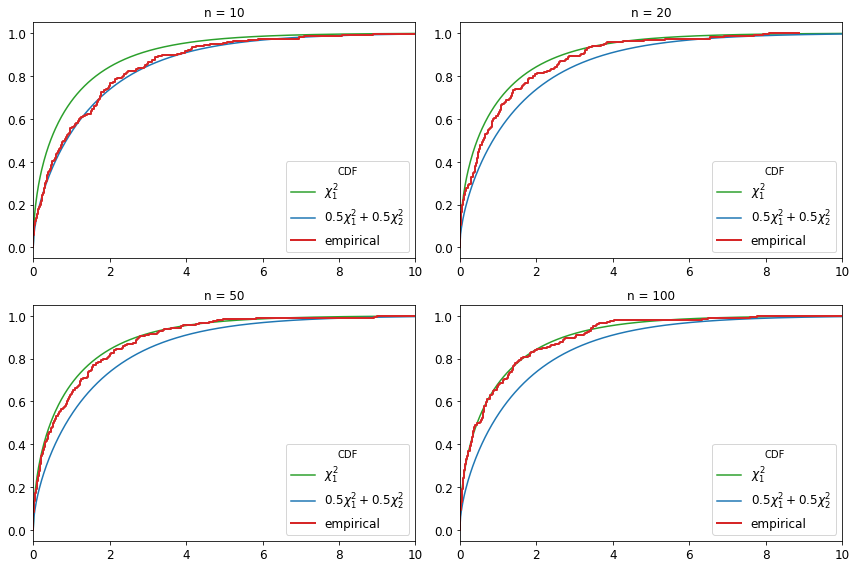

In [56]:
steps_val = np.linspace(0, 1, result.shape[1])
cdf_x = np.linspace(0, 10, 500)
chi1_val = chi2.cdf(cdf_x, df=1)
chi12_val = 0.5 * (chi2.cdf(cdf_x, df = 1) + chi2.cdf(cdf_x, df =2))

fig, axes = plt.subplots(nrows = 2, ncols = 2, **{'figsize' : (12, 8)})
for i in range(result.shape[0]):
    steps_x = np.sort(result[i,:])
    row, col = int(i//2.0), int(i%2)
    axes[row, col].plot(cdf_x, chi1_val, lw = 1.5, label = r"$\chi^2_1$", color = 'C2')
    axes[row, col].plot(cdf_x, chi12_val, lw = 1.5,
                        label = r"$0.5\chi^2_1 + 0.5\chi^2_2$", color = 'C0')
    axes[row, col].step(steps_x, steps_val, label = 'empirical', lw = 2, color = 'C3')
    axes[row, col].set_title("n = {}".format(n_list[i]), {'fontsize' : 'large'})
    axes[row, col].set_xlim(0, 10)
    axes[row, col].legend(title = 'CDF', loc = 'lower right', fontsize = 'large')
    axes[row, col].tick_params(labelsize = 'large')
fig.tight_layout()
fig.savefig("cdfs.eps")

## Confidence intervals

Calculating a $(1-\alpha)$-confidence interval from the data:

In [23]:
def get_ci(x1, x2, alpha, low, high, h, two_step, alpha_1):
    """
    :param x1, x2: data
    :param alpha: allowed type-I error
    :param low, high: range for testing c0's
    :param h: step length / distance between neighbouring c0's
    :param two_step: (bool) apply two-step approach
    :param alpha_1: alpha for first step of two-step procedure
    :returns: piecewise confidence interval
    """
    # 1st step
    if two_step:
        assert alpha_1 < alpha
    eps = 1e-6
    # Getting quantiles
    comp_1 = chi2.ppf(1 - alpha, df = 1) 
    if two_step:
        n = x1.shape[0]
        s11, s12, s22 = empirical_sigmas(x1, x2)
        # We use that simulated data is normal
        std = np.sqrt(2 * (s11**2 - 2 * s12 + s22**2))
        q = norm.ppf(1 - alpha_1/2)
        ci = (s11 - s22) + np.array([-q, q]) * std / np.sqrt(n)
        if ci[0] <= 0 <= ci[1]:
            comp_01 = chi2.ppf(1 - 2 * (alpha-alpha_1), df = 1)
            cdf_12 = lambda x: 0.5 * (chi2.cdf(x, df = 1) + chi2.cdf(x, df = 2))
            comp_12 = inversefunc(cdf_12, y_values = [1-(alpha-alpha_1)])[0]
        else:
            comp_01 = eps
            comp_12 = chi2.ppf(1 - (alpha-alpha_1), df = 1)
    else:
        comp_01 = chi2.ppf(1 - 2 * alpha, df = 1)
        cdf_12 = lambda x: 0.5 * (chi2.cdf(x, df = 1) + chi2.cdf(x, df = 2))
        comp_12 = inversefunc(cdf_12, y_values = [1-alpha])[0]
    
    # 2nd step
    S1_low, S1_high, S2 = [], [], []
    c0 = low
    while c0 <= high:
        s = statistic(x1, x2, c0)
        if c0 <= -1 and s <= comp_1:
            S1_low.append(c0)
        elif c0 >= 1 and s <= comp_1:
            S1_high.append(c0)
        elif 0 < np.abs(c0) < 1 and s <= comp_12:
            S2.append(c0)
        c0 = c0 + h
    
    def extract_ci(S):
        return np.array([min(S) - 0.5*h, max(S) + 0.5*h]) if len(S) > 0 else None
    I1_low = extract_ci(S1_low)
    I1_high = extract_ci(S1_high)
    I2 = extract_ci(S2)
    
    if low <= 0 <= high:
        s = statistic(x1, x2, 0)
        S3 = s <= comp_01
    else:
        S3 = False
    # I1_low, I1_high, I2 are nd-arrays; S3 is bool
    return I1_low, I1_high, I2, S3

Methods for calculating confidence intervals on simulated data and evaluating the results:

In [24]:
def contained(target, ci):
    """
    Checking wether a confidence interval contains the target.
    """
    found = False
    for index, I in enumerate(ci):
        if index < 3 and I is not None:
            found = found or (I[0] <= target <= I[1])
        else:
            found = found or (target == 0 and I)
    return found

def torn_ci(ci):
    """
    Checking wether a confidence interval is torn (True).
    """
    I1_low, I1_high, I2, S3 = ci
    eps = 1e-6
    if I2 is None and S3 and (I1_low is not None or I1_high is not None):
        return True
    elif I1_low is not None and I2 is None and I1_high is not None:
        return True
    elif I2 is not None and ((I2[0] <= 0 <= I2[1] and not S3) or
                             (not(I2[0] <= 0 <= I2[1]) and S3)):
        return True
    elif I1_low is not None and I2 is not None and I2[0] - I1_low[1] > eps:
        return True
    elif I1_high is not None and I2 is not None and I1_high[0] - I2[1] > eps:
        return True
    else:
        return False
    
def simulation_ci(n_list, rep, beta, sigma, x1_dep,
                  alpha = 0.05, h = 0.01, low = -2, high = 2,
                  two_step = False, alpha_1 = 0.01, start_seed = 2020):
    # parallelisation of computation
    def one_simulation(n, i, j):
        x1, x2 = data_generation(n, beta, sigma, x1_dep,
                                 seed = start_seed + i*rep + j)
        ci = get_ci(x1, x2, alpha, low, high, h, two_step, alpha_1)
        target = beta if x1_dep else 0
        c = contained(target, ci)
        t = torn_ci(ci)
        return c, t
    parallel = Parallel(n_jobs = -1)
    res = parallel(delayed(one_simulation)(n, i, j)
                   for i, n in enumerate(n_list) for j in range(rep))
    # extracting and transforming results
    res_contained = [rc for (rc, rt) in res]
    res_torn = [rt for (rc, rt) in res]
    res_contained = np.array(res_contained).reshape(len(n_list), rep)
    res_torn = np.array(res_torn).reshape(len(n_list), rep)
    # Averaging
    res_contained_avg = np.mean(res_contained, axis = 1)
    res_torn_avg = np.mean(res_torn, axis = 1)
    return res_contained_avg, res_torn_avg

Visualisation of results with and without broken y-axis:

In [ ]:
def visualisation_broken(n_list, res_contained, res_torn, alpha, legend_pos):
    """
    Plotting share of covering and torn confidence intervals
    leaving out [0.2, 0.8] on the y-axis.
    
    :param legend_pos: (tuple) 1st entry: legend in upper/lower plot; 2nd entry: position
    """
    fig, axes = plt.subplots(nrows = 2, ncols = 3, sharex = True, **{'figsize': (12, 4)})
    T = [r"standard", r"two-step, $\alpha_1 = 0.01$", r"two-step, $\alpha_1 = 0.02$"]
    
    for i, (res_c, res_t) in enumerate(zip(res_contained, res_torn)):
        # Plotting and unabling excessive ticks
        axes[0, i].plot(n_list, res_c, lw = 2, label = "covering CI's", color = 'C2')
        axes[1, i].plot(n_list, res_t, lw = 2, label = "torn CI's", color = 'C0')
        axes[0, i].hlines(y = 1-alpha, xmin = min(n_list), xmax = max(n_list),
                          label = r"$1-\alpha$", color = 'C3')
        axes[0, i].set_ylim(0.8, 1.02)
        axes[1, i].set_ylim(-0.02, 0.2)
        axes[0, i].spines['bottom'].set_visible(False)
        axes[1, i].spines['top'].set_visible(False)
        axes[0, i].tick_params(axis = 'x', which = 'both',
                               bottom = False, top = False, labelbottom = False)
        # Cut-out slanted lines
        d = .5
        kwargs = dict(marker=[(-1, -d), (1, d)], markersize = 12,
                      linestyle = "none", color = 'k', mec = 'k',
                      mew = 1, clip_on = False)
        axes[0, i].plot([0, 1], [0, 0], transform = axes[0, i].transAxes, **kwargs)
        axes[1, i].plot([0, 1], [1, 1], transform = axes[1, i].transAxes, **kwargs)
        # Title, ticks, labels
        axes[0, i].set_title(T[i], {'fontsize' : 'large'})
        axes[0, i].tick_params(labelsize = 'large')
        axes[1, i].tick_params(labelsize = 'large')
        axes[1, i].set_xlabel('sample size', fontsize = 'large')
        # Legend
        labels = ["covering CI's", "torn CI's", r"$1-\alpha$"]
        colors = ['C2', 'C0', 'C3']
        lines = [matplotlib.lines.Line2D([0], [0], color = c, label = l)
                 for c, l in zip(colors, labels)]
        axes[legend_pos[1], i].legend(handles = lines, loc = legend_pos[0],
                                      fontsize = 'large')
    fig.tight_layout()
    fig.savefig("figure.eps")
    fig.show()

In [ ]:
def visualisation(n_list, res_contained, res_torn, alpha, legend_pos):
    """
    Plotting share of covering and torn confidence intervals
    
    :param legend_pos: (tuple) 1st entry: not used; 2nd entry: position
    """
    fig, axes = plt.subplots(nrows = 1, ncols = 3, **{'figsize': (12, 4)})
    T = [r"standard", r"two-step, $\alpha_1 = 0.01$", r"two-step, $\alpha_1 = 0.02$"]
    for i, (res_c, res_t) in enumerate(zip(res_contained, res_torn)):
        # Plotting
        axes[i].plot(n_list, res_c, lw = 2, label = "covering CI's", color = 'C2')
        axes[i].plot(n_list, res_t, lw = 2, label = "torn CI's", color = 'C0')
        axes[i].hlines(y = 1-alpha, xmin = min(n_list), xmax = max(n_list),
                       label = r"$1-\alpha$", color = 'C3')
        axes[i].set_ylim(-0.02, 1.02)
        # Title, ticks, labels
        axes[i].set_title(T[i], {'fontsize' : 'large'})
        axes[i].tick_params(labelsize = 'large')
        axes[i].set_xlabel('sample size', fontsize = 'large')
        # Legend
        axes[i].legend(loc = legend_pos[0], fontsize = 'large')
    fig.tight_layout()
    fig.savefig("figure.eps")
    fig.show()

## Experiments

For the following experiments we fix $\sigma^2 = 1$ as it only appears as a scaling factor and thus does not qualitatively change the results. Moreover, we consider only non-negative values of $\beta$ due to symmetry and we set $\alpha = 0.05$.

Routine of one experiment:

In [ ]:
def experiment(n_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,
                         1200, 1400, 1600, 1800, 2000],
               rep = 200, beta = 1, sigma = 1, x1_dep = True, low = -1, high = 1,
               alpha = 0.05, legend_pos = ('center right', 0)):
    """
    Experiments for standard approach and two-step approach with alpha_1 = 0.01, 0.02
    and subsequent visualisation
    :param n_list: sample sizes
    :param rep: number of simulated datasets for each sample size
    :param beta, sigma, x1_dep: params for data generation
    :param low, high, alpha: params for confidence interval calculation
    :param legend_pos: placement of legend in plot
    """
    res_c_000, res_t_000 = simulation_ci(n_list, rep, beta, sigma, x1_dep,
                                         low = low, high = high, two_step = False)
    res_c_001, res_t_001 = simulation_ci(n_list, rep, beta, sigma, x1_dep,
                                         low = low, high = high, two_step = True, alpha_1 = 0.01)
    res_c_002, res_t_002 = simulation_ci(n_list, rep, beta, sigma, x1_dep,
                                         low = low, high = high, two_step = True, alpha_1 = 0.02)
    
    res_contained = [res_c_000, res_c_001, res_c_002]
    res_torn = [res_t_000, res_t_001, res_t_002]
    # Switching between plotting full y-axis or just [0, 0.2] and [0.8, 1]
    if np.any(res_t_000 > 0.2) or np.any(res_t_001 > 0.2) or np.any(res_t_002 > 0.2):
        visualisation(n_list, res_contained, res_torn, alpha, legend_pos)
    else:
        visualisation_broken(n_list, res_contained, res_torn, alpha, legend_pos)

#### $\beta = 0.5, X_1 \leftarrow X_2$

In [ ]:
experiment(rep = 500, beta = 0.5, low = -1, high = 2,
           legend_pos = ('center right', 0))

#### $\beta = 1.1, X_1 \leftarrow X_2$

In [ ]:
experiment(rep = 500, beta = 1.1, low = -0.4, high = 2.6,
           legend_pos = ('upper right', 1))

#### $\beta = 0.2, X_1 \leftarrow X_2$

In [ ]:
experiment(rep = 500, beta = 0.2, low = -1.3, high = 1.7,
           legend_pos = ('lower right', 0))

#### $\beta = 0$

In [ ]:
experiment(rep = 500, beta = 0, low = -1.5, high = 1.5,
           legend_pos = ('lower right', 0))

#### $\beta = 0.5, X_1 \rightarrow X_2$

In [ ]:
experiment(rep = 500, beta = 0.5, low = -1, high = 2, x1_dep = False,
           legend_pos = ('center right', 0))

## More Experiments
#### $\beta = 1, X_1 \leftarrow X_2$

In [ ]:
experiment(rep = 500, beta = 1, low = -0.5, high = 2.5,
           legend_pos = ('upper right', 1))

#### $\beta = 0.9, X_1 \leftarrow X_2$

In [ ]:
experiment(rep = 500, beta = 0.9, low = -0.6, high = 2.4,
           legend_pos = ('upper right', 1))

#### $\beta = 0.3, X_1 \leftarrow X_2$

In [ ]:
experiment(rep = 500, beta = 0.3, low = -1.2, high = 1.8,
           legend_pos = ('lower right', 0))

#### $\beta = 0.1, X_1 \leftarrow X_2$

In [ ]:
experiment(rep = 500, beta = 0.1, low = -1.4, high = 1.6,
           legend_pos = ('lower right', 0))

#### $\beta = 0.2, X_1 \rightarrow X_2$

In [ ]:
experiment(rep = 500, beta = 0.2, low = -1.3, high = 1.7, x1_dep = False,
           legend_pos = ('lower right', 0))

#### $\beta = 0.1, X_1 \rightarrow X_2$

In [ ]:
experiment(rep = 500, beta = 0.1, low = -1.4, high = 1.6, x1_dep = False,
           legend_pos = ('lower right', 0))